# A/A TESTS AND QUALITY CONTROL OF SPLITTING SYSTEMS

> Description of the task A / A testing of a mobile application. It is necessary to calculate the results of the A / A test by checking the FPR quality metric (we will check for conversions to a purchase). The split system is known to be broken. It is required to check the statement about the breakdown and find its causes if the split system is really broken.

Description of columns
experimentVariant - experiment variant
version - application version
purchase - fact of purchase

Calculate FPR at alpha level = 0.05 (set subsamples without replacement of 1000).
You will see that FPR > alpha! We need the opposite - to be less.
Find the causes of the breakdown of the split system, focusing on the results of the experiment (hint: find an anomaly in the application version).
Write conclusions that can be drawn from the analysis of the results of the A / A test.

We have access to the version of the mobile application (MP) of each user.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import StratifiedTable

from tqdm.auto import tqdm

In [3]:
df=pd.read_csv('hw_aa.csv', sep=';')

In [4]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [5]:
#check how many MP versions
df.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

In [6]:
df.uid.nunique()

127018

In [7]:
df['Unnamed: 0'].nunique()

127018

In [8]:
#check how many options we have
df.experimentVariant.unique()

array([1, 0])

Run an A/A test Calculate FPR at alpha level = 0.05 (set subsamples without return of size 1000). You will see that FPR > alpha! We need the opposite - to be less.

In [9]:
df[df.experimentVariant == 0]['purchase']
df[df.experimentVariant == 1]['purchase']

0         0
2         0
3         0
4         0
5         0
         ..
127009    0
127010    0
127015    0
127016    0
127017    0
Name: purchase, Length: 63916, dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]

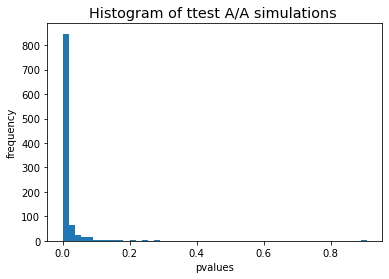

0.93

In [10]:
n = 127018
simulations = 1000
n_s = 1000
res = []

# Run A/A test simulations
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Check that the number of false positives does not exceed alpha
sum(np.array(res) <0.05) / simulations

Detection of splitting errors. Let's check the conversion for different MPs.

In [11]:
#we will check the purchase concession from different SEs in different experimental groups.
df1=df.groupby(['version', 'experimentVariant']).agg({'purchase':'mean'}).reset_index()\
                                                .rename(columns={'purchase':'ctr'})
df1

,version,experimentVariant,ctr
0,v2.8.0,0,0.000993
1,v2.8.0,1,0.045606
2,v2.9.0,0,0.074658
3,v2.9.0,1,0.071304
4,v3.7.4.0,0,0.059943
5,v3.7.4.0,1,0.063018
6,v3.8.0.0,0,0.057604
7,v3.8.0.0,1,0.062848


<AxesSubplot:xlabel='version', ylabel='ctr'>

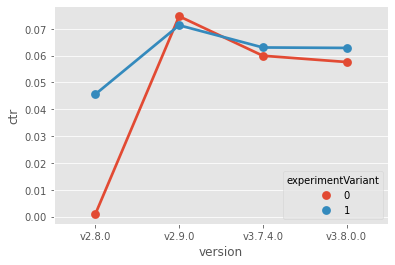

In [12]:
#There is a noticeable difference in v2.8.0, in others it is present, but not so significant
sns.pointplot(x = 'version', y = 'ctr', hue = 'experimentVariant', data = df1)

In [13]:
#we will check the purchase concession from different SEs in different experimental groups.
df2=df.groupby(['version', 'experimentVariant']).agg({'purchase':'mean', 'uid':'count'}).reset_index()
df2

,version,experimentVariant,purchase,uid
0,v2.8.0,0,0.000993,41283
1,v2.8.0,1,0.045606,41552
2,v2.9.0,0,0.074658,11921
3,v2.9.0,1,0.071304,12033
4,v3.7.4.0,0,0.059943,4204
5,v3.7.4.0,1,0.063018,4221
6,v3.8.0.0,0,0.057604,5694
7,v3.8.0.0,1,0.062848,6110


<AxesSubplot:xlabel='version', ylabel='uid'>

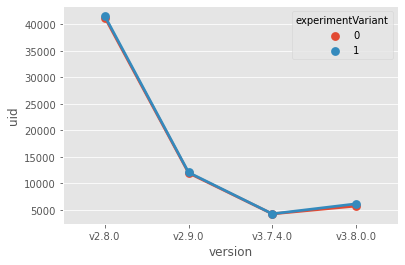

In [14]:
#Sampling sizes are nearly identical, with this being the largest portion in the version where the biggest difference in concession is noticeable.
sns.pointplot(x = 'version', y = 'uid', hue = 'experimentVariant', data = df2)

  0%|          | 0/1000 [00:00<?, ?it/s]

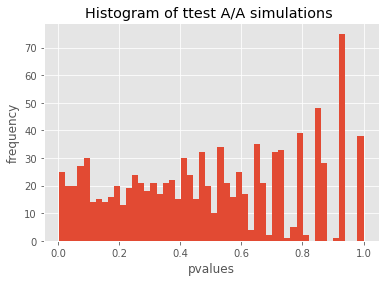

0.053

In [15]:
n = 127018
simulations = 1000
n_s = 1000
res = []


# Run A/A test simulations
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 0) & (df.version != "v2.8.0")]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 1) & (df.version != "v2.8.0")]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Check that the number of false positives does not exceed alpha
sum(np.array(res) <0.05) / simulations

In [16]:
StratifiedTable.from_data('purchase', 'experimentVariant', 'version', df).summary()

# Here we are interested in p-value.
# The first line (where Test of OR = 1) is a test of the hypothesis about the independence of variables,
# the second line (where Test constant OR) is a test of the hypothesis that the relationship is the same for all levels of the stratifying variable.

,Estimate,LCB,UCB
Pooled odds,2.300,2.161,2.447
Pooled log odds,0.833,0.771,0.895
Pooled risk ratio,1.657,,
,,,
,Statistic,P-value,
Test of OR=1,734.655,0.000,
Test constant OR,1256.880,0.000,
,,,
Number of tables,4,,
Min n,8425,,


> Conclusion: did an AA test, revealed a problem in splitting, p value (0.935) > 0.05.
We checked where the ctr distributions (calculated via mean) have a noticeable deviation between 0 and 1.
MP version v2.8.0 spills extremely heavily in groups 0 and 1 with approximately uniform samples in number.
We did the AA test again, removing v2.8.0 from MP, p value (0.04) < 0.05
We can assume that the problem is splitting in MP v2.8.0.

>Also, for the sake of interest, we did a test of the Cochran-Mantel-Hanzel criterion. p-value on the line Test of OR=1 shows that there is a connection, and p-value on the line Test constant OR shows that the connection is heterogeneous.